Epoch 0, Loss: 17.30849266052246
Epoch 1000, Loss: 0.0007302975282073021
Epoch 2000, Loss: 0.00046283731353469193
Epoch 3000, Loss: 0.0003597854229155928
Epoch 4000, Loss: 0.0003156546736136079
Epoch 5000, Loss: 0.00030490668723359704
Epoch 6000, Loss: 0.00029510576860047877
Epoch 7000, Loss: 0.0002861385582946241
Epoch 8000, Loss: 0.0002818117500282824
Epoch 9000, Loss: 0.00027330630109645426
Epoch 10000, Loss: 0.00026776670711115
Epoch 11000, Loss: 0.006177071016281843
Epoch 12000, Loss: 0.00027527654310688376
Epoch 13000, Loss: 0.0002621323801577091
Epoch 14000, Loss: 0.0002628722577355802
Epoch 15000, Loss: 0.00028988270787522197
Epoch 16000, Loss: 0.0002532322541810572
Epoch 17000, Loss: 0.00026110850740224123
Epoch 18000, Loss: 0.0003676730557344854
Epoch 19000, Loss: 0.00026802110369317234
Epoch 20000, Loss: 0.00024458765983581543
Epoch 21000, Loss: 0.0002268540411023423
Epoch 22000, Loss: 0.00023367263202089816
Epoch 23000, Loss: 0.0002218932204414159
Epoch 24000, Loss: 0.00027

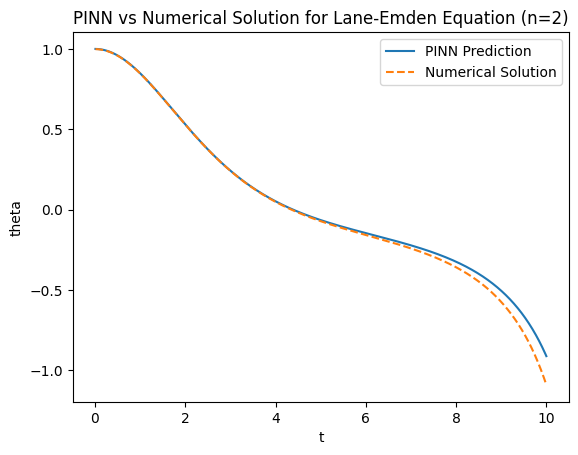

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the neural network model with different activation functions for each layer
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers_list = [
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='sigmoid'),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(64, activation='softplus'),
            tf.keras.layers.Dense(64, activation='elu'),
            tf.keras.layers.Dense(1, activation='linear')
        ]

    def call(self, t):
        x = t
        for layer in self.layers_list:
            x = layer(x)
        return x

# Define the Lane-Emden residual
def lane_emden_residual(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        theta = model(t)
        dtheta_dt = tape.gradient(theta, t)
    d2theta_dt2 = tape.gradient(dtheta_dt, t)
    residual = d2theta_dt2 + (2/t) * dtheta_dt + tf.math.pow(theta, 2)
    return residual

# Define the loss function including boundary conditions
def loss(model, t, t_boundary, theta_boundary, dtheta_dt_boundary):
    residual = lane_emden_residual(model, t)
    boundary_loss = tf.reduce_mean(tf.square(model(t_boundary) - theta_boundary)) + \
                    tf.reduce_mean(tf.square(tf.gradients(model(t_boundary), t_boundary)[0] - dtheta_dt_boundary))
    return tf.reduce_mean(tf.square(residual)) + boundary_loss

# Training step
@tf.function
def train_step(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, optimizer):
    with tf.GradientTape() as tape:
        loss_value = loss(model, t, t_boundary, theta_boundary, dtheta_dt_boundary)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

# Generate training data
def generate_training_data(num_points):
    t = np.linspace(0.01, 10, num_points).reshape(-1, 1)
    return t

# Solve the Lane-Emden equation using a numerical method
def solve_lane_emden_numerically(n, t_max, num_points):
    def lane_emden_rhs(t, y, n):
        theta, theta_prime = y
        return [theta_prime, -2/t * theta_prime - theta**n]

    t_eval = np.linspace(0.01, t_max, num_points)
    sol = solve_ivp(lane_emden_rhs, [0.01, t_max], [1, 0], args=(n,), t_eval=t_eval)
    return sol.t, sol.y[0]

if __name__ == "__main__":
    num_points = 1000
    t = generate_training_data(num_points)
    t = tf.convert_to_tensor(t, dtype=tf.float32)

    # Boundary conditions
    t_boundary = tf.convert_to_tensor([[0.01]], dtype=tf.float32)
    theta_boundary = tf.convert_to_tensor([[1.0]], dtype=tf.float32)
    dtheta_dt_boundary = tf.convert_to_tensor([[0.0]], dtype=tf.float32)

    model = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    epochs = 40001
    for epoch in range(epochs):
        loss_value = train_step(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, optimizer)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')

    # Predict with the PINN model
    t_test = np.linspace(0.01, 10, num_points).reshape(-1, 1)
    theta_pred = model.predict(t_test)

    # Solve the equation numerically
    t_num, theta_num = solve_lane_emden_numerically(n=2, t_max=10, num_points=num_points)

    # Plot the results
    plt.plot(t_test, theta_pred, label='PINN Prediction')
    plt.plot(t_num, theta_num, label='Numerical Solution', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('theta')
    plt.legend()
    plt.title('PINN vs Numerical Solution for Lane-Emden Equation (n=2)')
    plt.show()